In [1]:
import pandas as pd
import numpy as np
np.random.seed(314)
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH_LUCY = '/content/drive/MyDrive/TA_weather/black-rock'

In [4]:
df = pd.read_csv(PATH_LUCY + '/y2008m01d05.ped.diff.csv', header=None, 
                 names=['part','minute','mirror','tube','avg_diff','rms_diff','flag'])
df.head()

,part,minute,mirror,tube,avg_diff,rms_diff,flag
0,3,0,0,0,5,-2,1
1,3,0,0,1,5,-10,1
2,3,0,0,2,3,-7,1
3,3,0,0,3,4,-9,1
4,3,0,0,4,10,-7,1


This is the file with meta data for the experiment. It contains the date of the run night, parts of that night and weather status with '0' for clear weather, '1' for cloudy, '2' for noisy data where the weather couldn't be determined and 'missing' for missing data.

In [5]:
meta_file = '/content/drive/MyDrive/TA_weather/training_br_fd_ped_db_by_part_classified.csv'
meta_df = pd.read_csv(meta_file)
meta_df.head()

,Unnamed: 0,run_night,part,part_weather_status
0,0,2007-11-07,4,0
1,1,2007-11-07,5,0
2,2,2007-11-07,8,0
3,3,2007-11-07,9,0
4,4,2007-11-07,15,0


In [7]:
meta_df.dtypes

Unnamed: 0              int64
run_night              object
part                    int64
part_weather_status    object
dtype: object

We only will look at data taken on clear or cloudy nights.

In [7]:
clean_meta_df = meta_df[(meta_df.part_weather_status != 'Missing') & (meta_df.part_weather_status != '2')]
clean_meta_df.head()

,Unnamed: 0,run_night,part,part_weather_status
0,0,2007-11-07,4,0
1,1,2007-11-07,5,0
2,2,2007-11-07,8,0
3,3,2007-11-07,9,0
4,4,2007-11-07,15,0


In [9]:
clean_meta_df.shape[0]

3912

To consider a time series of images in our model we need to have a tensor of dimensions T x Width x Height x 1 (grey scale images). So we need to choose the same number of minutes T in each part. For each part we will either truncate the number of minutes to T, or pad the number of minutes to T with zero data.

In [8]:
current_file = 'rabbit'
last_minutes = []
for i, row in clean_meta_df.iterrows():
  ymd = row.run_night.split('-')
  y, m, d = ymd[0], ymd[1], ymd[2]
  file_name = 'y' + y + 'm' + m + 'd' + d +'.ped.diff.csv'
  if file_name != current_file:
    if os.path.exists('/content/drive/MyDrive/TA_weather/black-rock/' + file_name):
      df = pd.read_csv('/content/drive/MyDrive/TA_weather/black-rock/' + file_name, header=None, 
                 names=['part','minute','mirror','tube','avg_diff','rms_diff','flag'])
            # print(file_name)
      current_file = file_name
    else:
      continue
  if len(df[df.part == row.part].minute.values):
    m = df[df.part == row.part].minute.values[-1]
    last_minutes.append(m)
  else:
    continue

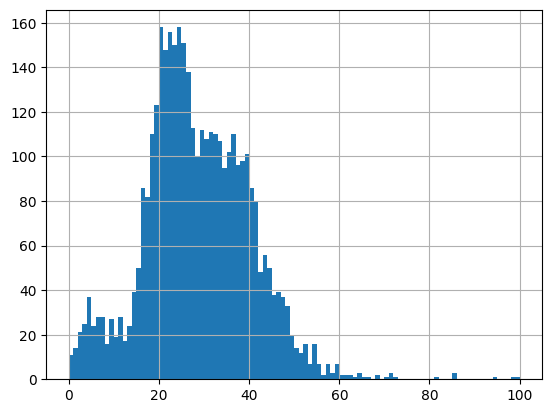

In [11]:
plt.hist(last_minutes,100,(0,100))
plt.grid()

We will choose T = 42.

In [9]:
clean_meta_df.insert(4, "file_exists", 0)
clean_meta_df.head()

,Unnamed: 0,run_night,part,part_weather_status,file_exists
0,0,2007-11-07,4,0,0
1,1,2007-11-07,5,0,0
2,2,2007-11-07,8,0,0
3,3,2007-11-07,9,0,0
4,4,2007-11-07,15,0,0


We select a subset of clean_meta_df for which we have files.

In [10]:
for i in range(clean_meta_df.shape[0]):
  ymd = clean_meta_df.iloc[i].run_night.split('-')
  y, m, d = ymd[0], ymd[1], ymd[2]
  file_name = 'y' + y + 'm' + m + 'd' + d +'.ped.diff.csv'
  if os.path.exists('/content/drive/MyDrive/TA_weather/black-rock/' + file_name):
    clean_meta_df.iloc[i,4] = 1

In [11]:
file_exists_meta_df = clean_meta_df.loc[clean_meta_df.file_exists==1]
file_exists_meta_df.head()

,Unnamed: 0,run_night,part,part_weather_status,file_exists
51,51,2008-01-02,3,0,1
52,52,2008-01-02,4,0,1
53,53,2008-01-02,5,0,1
54,54,2008-01-02,6,0,1
55,55,2008-01-02,8,0,1


We split our data into training and validation dataframes.

In [15]:
split = np.random.permutation(file_exists_meta_df.shape[0])
split_size = file_exists_meta_df.shape[0] // 3
valid_idx = split[:split_size]
valid_idx_sorted = np.sort(valid_idx)
train_idx = split[split_size:]
train_idx_sorted = np.sort(train_idx)
valid_meta_df = file_exists_meta_df.iloc[valid_idx_sorted]
train_meta_df = file_exists_meta_df.iloc[train_idx_sorted]

We convert mirrors and tubes numbers into width and height coordinates of our image.

In [16]:
# index for the features
mirtub2img = np.empty((32, 96), dtype=int)
mir0 = np.empty((16,16),dtype=int)
mir0[15,:] = np.arange(0,256,16)
for i in range(15,0,-1):
  mir0[i-1,:] = mir0[i,:]+1
mirtub2img[ 0:16,0*16:1*16] = mir0
mirtub2img[16:32,0*16:1*16] = mir0 +  1*256
mirtub2img[ 0:16,1*16:2*16] = mir0 +  2*256
mirtub2img[16:32,1*16:2*16] = mir0 +  3*256
mirtub2img[ 0:16,2*16:3*16] = mir0 +  4*256
mirtub2img[16:32,2*16:3*16] = mir0 +  5*256
mirtub2img[ 0:16,3*16:4*16] = mir0 +  6*256
mirtub2img[16:32,3*16:4*16] = mir0 +  7*256
mirtub2img[ 0:16,4*16:5*16] = mir0 +  8*256
mirtub2img[16:32,4*16:5*16] = mir0 +  9*256
mirtub2img[ 0:16,5*16:6*16] = mir0 + 10*256
mirtub2img[16:32,5*16:6*16] = mir0 + 11*256
mirtub2img

array([[  15,   31,   47, ..., 2783, 2799, 2815],
       [  14,   30,   46, ..., 2782, 2798, 2814],
       [  13,   29,   45, ..., 2781, 2797, 2813],
       ...,
       [ 258,  274,  290, ..., 3026, 3042, 3058],
       [ 257,  273,  289, ..., 3025, 3041, 3057],
       [ 256,  272,  288, ..., 3024, 3040, 3056]])

The generator function

In [17]:
# data generator function for timeseries with minibatches
def ta_weather_timeseries_data_gen(meta_df, mirtub2img, batch_size=32):
  # SCALE = 10000 # makes the values in X between -0.5 and 0.5
  T = 42 # number of timesteps
  SCALE = 100
  NUM_BATCHES = meta_df.shape[0] // batch_size + 1
  current_file = 'rabbit'
  while True:
    for i in range(NUM_BATCHES):
      M = min(len(meta_df) - i * batch_size, batch_size)
      X_minibatch = np.zeros((M, T, 32, 96, 1),dtype=float)
      Y_minibatch = np.ones((M, ),dtype=float) 
      for j in range(M):
        idx = i * batch_size + j
        if idx >= meta_df.shape[0]:
          break
        ymd = meta_df.iloc[idx].run_night.split('-')
        y, m, d = ymd[0], ymd[1], ymd[2]
        file_name = 'y' + y + 'm' + m + 'd' + d +'.ped.diff.csv'
        if file_name != current_file:
          if os.path.exists('/content/drive/MyDrive/TA_weather/black-rock/' + file_name):
            df = pd.read_csv('/content/drive/MyDrive/TA_weather/black-rock/' + file_name,header=None, 
                 names=['part','minute','mirror','tube','avg_diff','rms_diff','flag'])
            # print(file_name)
            current_file = file_name
          else:
            continue

        # select the current part of the dataframe 
        df_part = df.loc[df.part == meta_df.iloc[idx].part]
        if df_part.shape[0] < 3072:
          continue
        # print('part:', meta_df.iloc[idx].part)

        # select the current minute
        if len(df_part.minute.values):
          L = min(T-1,df_part.minute.values[-1])

        for m in range(L + 1):
          xhat = df_part[df_part.minute == m].avg_diff.values
          flag = df_part[df_part.minute == m].flag.values
          xhat[flag == 0] = 0
          xhat = xhat / SCALE
          x = xhat[mirtub2img]
          y = int(meta_df.iloc[idx].part_weather_status)

          X_minibatch[j,m] = np.expand_dims(x,-1)
          Y_minibatch[j] = y

      yield X_minibatch, Y_minibatch

In [18]:
import tensorflow as tf
tf.random.set_seed(314)

from keras.models import Model
from keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D, GRU, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam
from keras.metrics import BinaryCrossentropy

We use a simple CNN model to analyse one image. We tried several other architectures for this task, but simple CNN seems to perform best. This might be because of the small size of our dataset.

In [19]:
class SimpleCNN(tf.keras.Model):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.act = tf.keras.layers.Activation('relu')
    self.conv1 = tf.keras.layers.Conv2D(16, 5, padding='same')
    self.max_pool1 = tf.keras.layers.MaxPool2D(pool_size=(1,3))
    self.conv2 = tf.keras.layers.Conv2D(32, 5, padding='same')
    self.max_pool2 = tf.keras.layers.MaxPool2D(pool_size=(4,4))
    self.conv3 = tf.keras.layers.Conv2D(64, 5, padding='same')
    self.max_pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.flatten = tf.keras.layers.Flatten()
    

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.act(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    x = self.act(x)
    x = self.max_pool2(x)
    x = self.conv3(x)
    x = self.act(x)
    x = self.max_pool3(x)
    x = self.flatten(x)
    return x

We now construct our model.

In [23]:
class WeatherPredictor(tf.keras.Model):
  def __init__(self):
    super(WeatherPredictor,self).__init__()
    self.act = tf.keras.layers.Activation('relu')
    self.simple_cnn = SimpleCNN()
    self.timedistributed = tf.keras.layers.TimeDistributed(self.simple_cnn)
    self.gru = tf.keras.layers.GRU(16, return_sequences=False)
    # self.lstm = tf.keras.layers.LSTM(16, return_sequences=False)
    self.bidirectional = tf.keras.layers.Bidirectional(self.gru)
    self.dense = tf.keras.layers.Dense(256)
    self.dropout = tf.keras.layers.Dropout(0.4)
    self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self,inputs):
    x = self.timedistributed(inputs)
    x = self.bidirectional(x)
    x = self.dense(x)
    x = self.act(x)
    x = self.dropout(x)
    return self.classifier(x)

In [24]:
model = WeatherPredictor() 
model.compile(
    # optimizer = tf.keras.optimizers.experimental.SGD(0.1, momentum=0.9)
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [25]:
r = model.fit(ta_weather_timeseries_data_gen(train_meta_df,mirtub2img,batch_size=32),
              steps_per_epoch=train_meta_df.shape[0]//32+1,
              validation_data=ta_weather_timeseries_data_gen(valid_meta_df,mirtub2img,batch_size=32),
              validation_steps=valid_meta_df.shape[0]//32+1,
              batch_size=32, validation_batch_size=32, epochs=5)

Epoch 1/5
81/81 [==============================] - 1172s 14s/step - loss: 0.5318 - binary_accuracy: 0.7550 - val_loss: 0.3875 - val_binary_accuracy: 0.8485
Epoch 2/5
81/81 [==============================] - 1187s 15s/step - loss: 0.3273 - binary_accuracy: 0.8800 - val_loss: 0.3035 - val_binary_accuracy: 0.8780
Epoch 3/5
81/81 [==============================] - 1187s 15s/step - loss: 0.2412 - binary_accuracy: 0.9118 - val_loss: 0.2755 - val_binary_accuracy: 0.8951
Epoch 4/5
81/81 [==============================] - 1175s 15s/step - loss: 0.2024 - binary_accuracy: 0.9258 - val_loss: 0.2404 - val_binary_accuracy: 0.9060
Epoch 5/5
81/81 [==============================] - 1130s 14s/step - loss: 0.1921 - binary_accuracy: 0.9297 - val_loss: 0.2043 - val_binary_accuracy: 0.9285


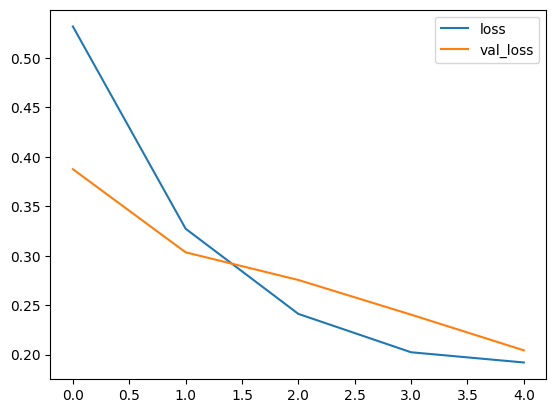

In [26]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend();

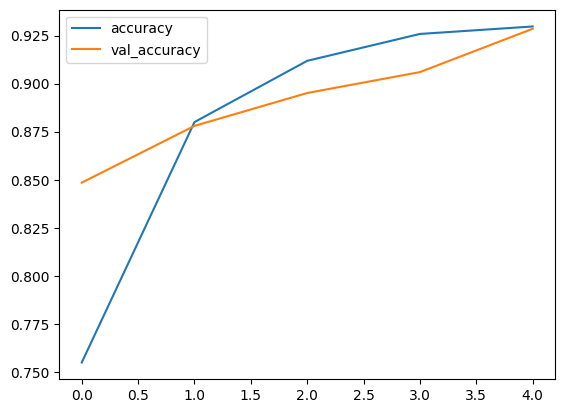

In [27]:
plt.plot(r.history['binary_accuracy'],label='accuracy')
plt.plot(r.history['val_binary_accuracy'],label='val_accuracy')
plt.legend();

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
y_true = False
y_pred = False
for x, y in ta_weather_timeseries_data_gen(valid_meta_df,mirtub2img,batch_size=32):
  if y_true is False or y_pred is False:
    y_true = y
    y_pred = np.round(model.predict(x))
  else:   
    y_true = np.concatenate((y_true,y))
    y_pred = np.concatenate((y_pred,np.round(model.predict(x))), axis=None)
  if y_true.shape[0] >= valid_meta_df.shape[0]:
    break

1/1 [==============================] - 2s 2s/step


In [30]:
confusion_matrix(y_true,y_pred)

array([[794,  22],
       [ 70, 401]])